In [1]:
# !rm -r autonomous_car_driving
!git clone https://github.com/sharathrjtr/autonomous_car_driving.git
!ls autonomous_car_driving/track_train_data

Cloning into 'autonomous_car_driving'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 34927 (delta 0), reused 4 (delta 0), pack-reused 34922
Receiving objects: 100% (34927/34927), 454.00 MiB | 30.73 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (12767/12767), done.
driving_log.csv  IMG


In [2]:
!pip install imgaug

In [0]:
import numpy as np
import os
import ntpath
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import random

In [21]:
# path to csv file
datadir = 'autonomous_car_driving/track_train_data'

# the data columns are ordered in the following list
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
# Load the csv file
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names=columns)
# limit the column width
pd.set_option('display.max_colwidth', None)

# display the top 5 samples in data frame
data.head()

center  ...     speed
0  /home/sj/transforma/learning/udemy/The Complete Self-Driving Car Course - Applied Deep Learning/autonomous_car_driving/track_train_data_2/IMG/center_2019_08_25_21_17_56_903.jpg  ...  0.000078
1  /home/sj/transforma/learning/udemy/The Complete Self-Driving Car Course - Applied Deep Learning/autonomous_car_driving/track_train_data_2/IMG/center_2019_08_25_21_17_57_008.jpg  ...  0.000078
2  /home/sj/transforma/learning/udemy/The Complete Self-Driving Car Course - Applied Deep Learning/autonomous_car_driving/track_train_data_2/IMG/center_2019_08_25_21_17_57_110.jpg  ...  0.000079
3  /home/sj/transforma/learning/udemy/The Complete Self-Driving Car Course - Applied Deep Learning/autonomous_car_driving/track_train_data_2/IMG/center_2019_08_25_21_17_57_212.jpg  ...  0.000079
4  /home/sj/transforma/learning/udemy/The Complete Self-Driving Car Course - Applied Deep Learning/autonomous_car_driving/track_train_data_2/IMG/center_2019_08_25_21_17_57_321.jpg  ...  0.000080

[5 rows x 7 columns]

In [14]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
  
# retain only the names of center, left and right images
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center  ...     speed
0  center_2019_08_25_21_17_56_903.jpg  ...  0.000078
1  center_2019_08_25_21_17_57_008.jpg  ...  0.000078
2  center_2019_08_25_21_17_57_110.jpg  ...  0.000079
3  center_2019_08_25_21_17_57_212.jpg  ...  0.000079
4  center_2019_08_25_21_17_57_321.jpg  ...  0.000080

[5 rows x 7 columns]

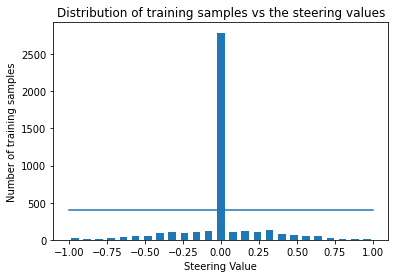

In [15]:
# Distribution of training samples against the steering values
num_bins = 25
samples_per_bin = 400

# find histogram by dividing the steering values into 25 bins
hist, bins = np.histogram(data['steering'], num_bins)
# calculate the center value of the bins
center = (bins[:-1]+bins[1:])/2

# plot bar graph for the histogram
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
plt.xlabel('Steering Value')
plt.ylabel('Number of training samples')
plt.title('Distribution of training samples vs the steering values')
plt.savefig('histogram_images_vs_steering_anlges.png')

total data:  4254
removed:  2388
remaining:  1866


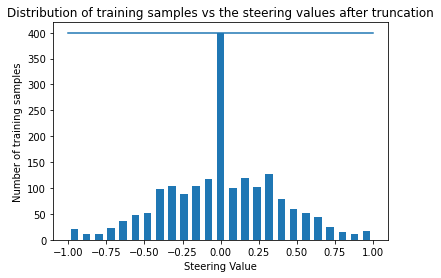

In [17]:
print('total data: ', len(data))
# find the list of images that have to be removed from the data frame.
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] < bins[j+1]:
      list_.append(i)
  # the samples indices to be removed are found by shuffling the list of sample indices available for each bin of steering values
  list_ = shuffle(list_)

  # all the samples beyond the required number of samples per bin are added into remove list.
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed: ', len(remove_list))
# remove the data from data frame
data.drop(data.index[remove_list], inplace=True)
print('remaining: ', len(data))

# plot the histogram after truncation
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
plt.xlabel('Steering Value')
plt.ylabel('Number of training samples')
plt.title('Distribution of training samples vs the steering values after truncation')
plt.savefig('truncated_histogram.png')

In [18]:
print(data.iloc[1])

# function to load all training input images full path and  target steering values as list.
def load_img_steering(datadir, df):
  image_path=[]
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    
    # center image append
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    
    # left and right images act as extra data
    # left image append. 
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)

  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

# load the training input images and training target steering values
image_paths, steerings = load_img_steering(datadir+'/IMG', data)

center      center_2019_08_25_21_17_57_627.jpg
left        left_2019_08_25_21_17_57_627.jpg  
right       right_2019_08_25_21_17_57_627.jpg 
steering    0                                 
throttle    0                                 
reverse     0                                 
speed       7.88335e-05                       
Name: 7, dtype: object


In [22]:
# split the dataset into training and validation set in ratio of 80:20
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(str(len(X_train)), str(len(X_valid))))

print(X_train[0])
print(image_paths[0])

Training Samples: 4478
Valid Samples: 1120
autonomous_car_driving/track_train_data/IMG/center_2019_08_25_21_22_41_697.jpg
autonomous_car_driving/track_train_data/IMG/center_2019_08_25_21_17_57_212.jpg


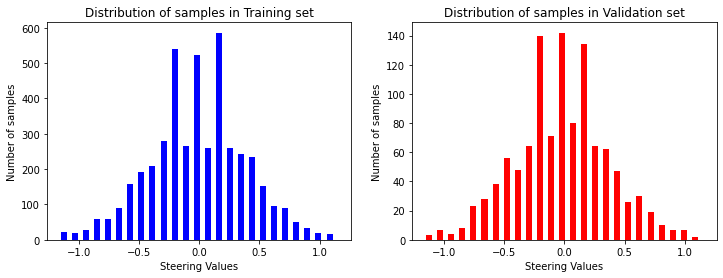

In [26]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
ax[0].set_title('Distribution of samples in Training set')
ax[0].set_xlabel('Steering Values')
ax[0].set_ylabel('Number of samples')
ax[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
ax[1].set_title('Distribution of samples in Validation set')
ax[1].set_xlabel('Steering Values')
ax[1].set_ylabel('Number of samples')
fig.savefig('Distribution_training_validation.png')

In [0]:
# function to apply zoom operation of imgaug
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed Image')

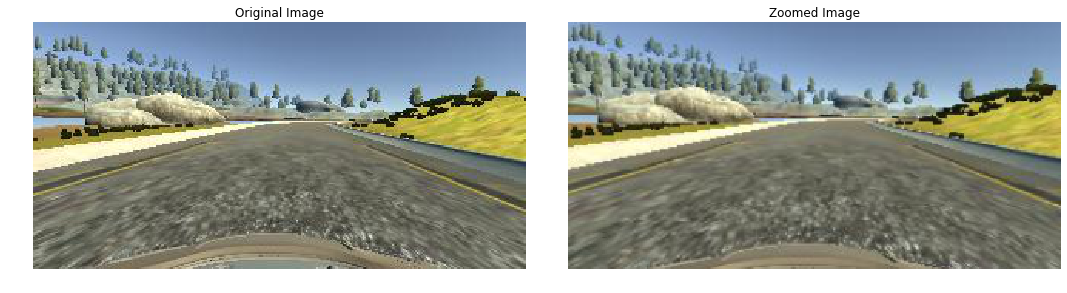

In [0]:
# load a random image and visualize the random zoom operation applied on the image
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axes = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axes[0].imshow(original_image)
axes[0].axis('off')
axes[0].set_title('Original Image')
axes[1].imshow(zoomed_image)
axes[1].axis('off')
axes[1].set_title('Zoomed Image')

In [0]:
# function to apply random translation operation of imgaug. Translation is applied with 10% shift in x or y direction.
def pan(image):
  pan = iaa.Affine(translate_percent={"x":(-0.1, 0.1), "y":(-0.1,0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned Image')

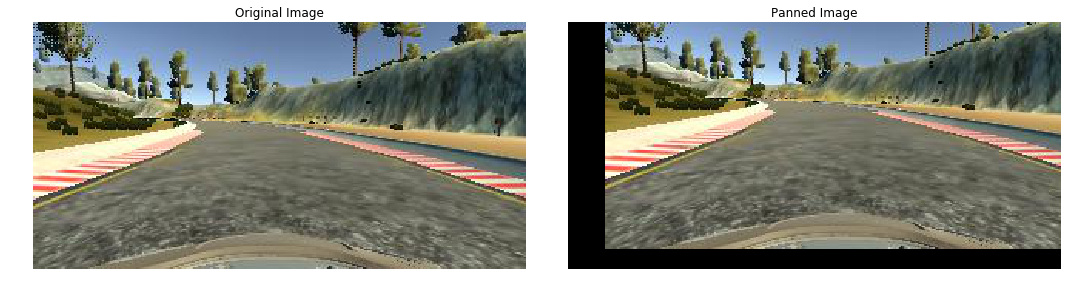

In [0]:
# load a random image and visualize the random translation operation applied on the image
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axes = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axes[0].imshow(original_image)
axes[0].axis('off')
axes[0].set_title('Original Image')
axes[1].imshow(panned_image)
axes[1].axis('off')
axes[1].set_title('Panned Image')

In [0]:
# function to randomly increase or decrease brightness of the image.
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2,1.2))
  image = brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'Brightness Altered Image')

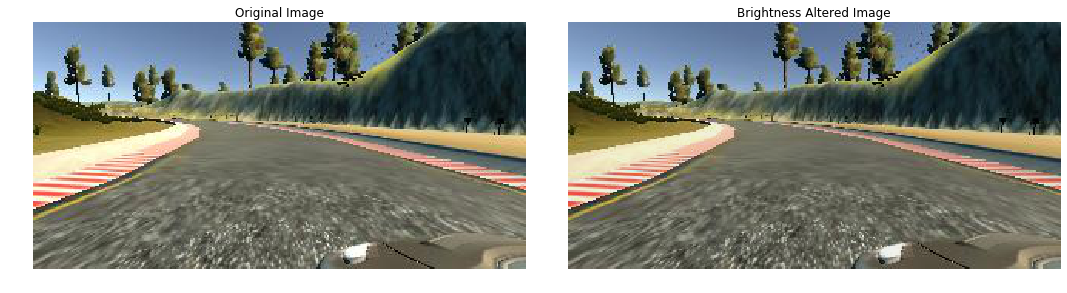

In [0]:
# load a random image and visualize the random brightness change operation applied on the image
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axes = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axes[0].imshow(original_image)
axes[0].axis('off')
axes[0].set_title('Original Image')
axes[1].imshow(brightness_altered_image)
axes[1].axis('off')
axes[1].set_title('Brightness Altered Image')

In [0]:
# function to flip image horizontally. Steering angle is also inverted after flipping.
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1) #0: vertical flip, 1: horizontal flip, -1: combination of vertical and horizontal flip
  steering_angle = -1*steering_angle
  return image, steering_angle

Text(0.5, 1.0, 'Flipped Image - Steering Angle: -0.0')

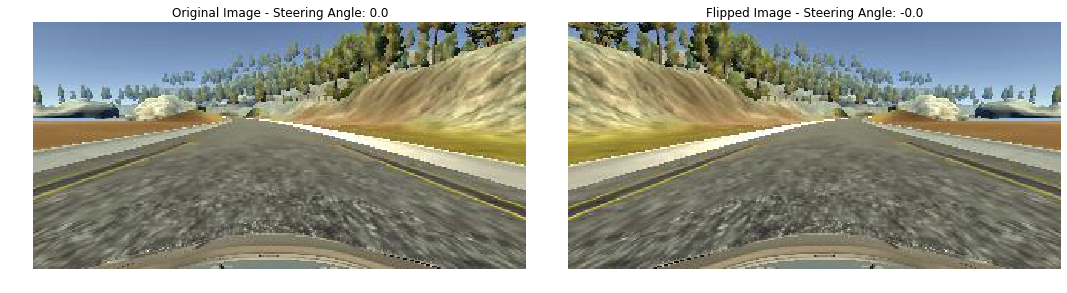

In [0]:
# load a random image and visualize the horizontal flip operation applied on the image
random_index = random.randint(0,1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
original_image = mpimg.imread(image)

flipped_image, steering_angle_flip = img_random_flip(original_image, steering_angle)


fig, axes = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axes[0].imshow(original_image)
axes[0].axis('off')
axes[0].set_title('Original Image - '+'Steering Angle: ' + str(steering_angle))
axes[1].imshow(flipped_image)
axes[1].axis('off')
axes[1].set_title('Flipped Image - '+'Steering Angle: ' + str(steering_angle_flip))

In [0]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)
    
  return image, steering_angle

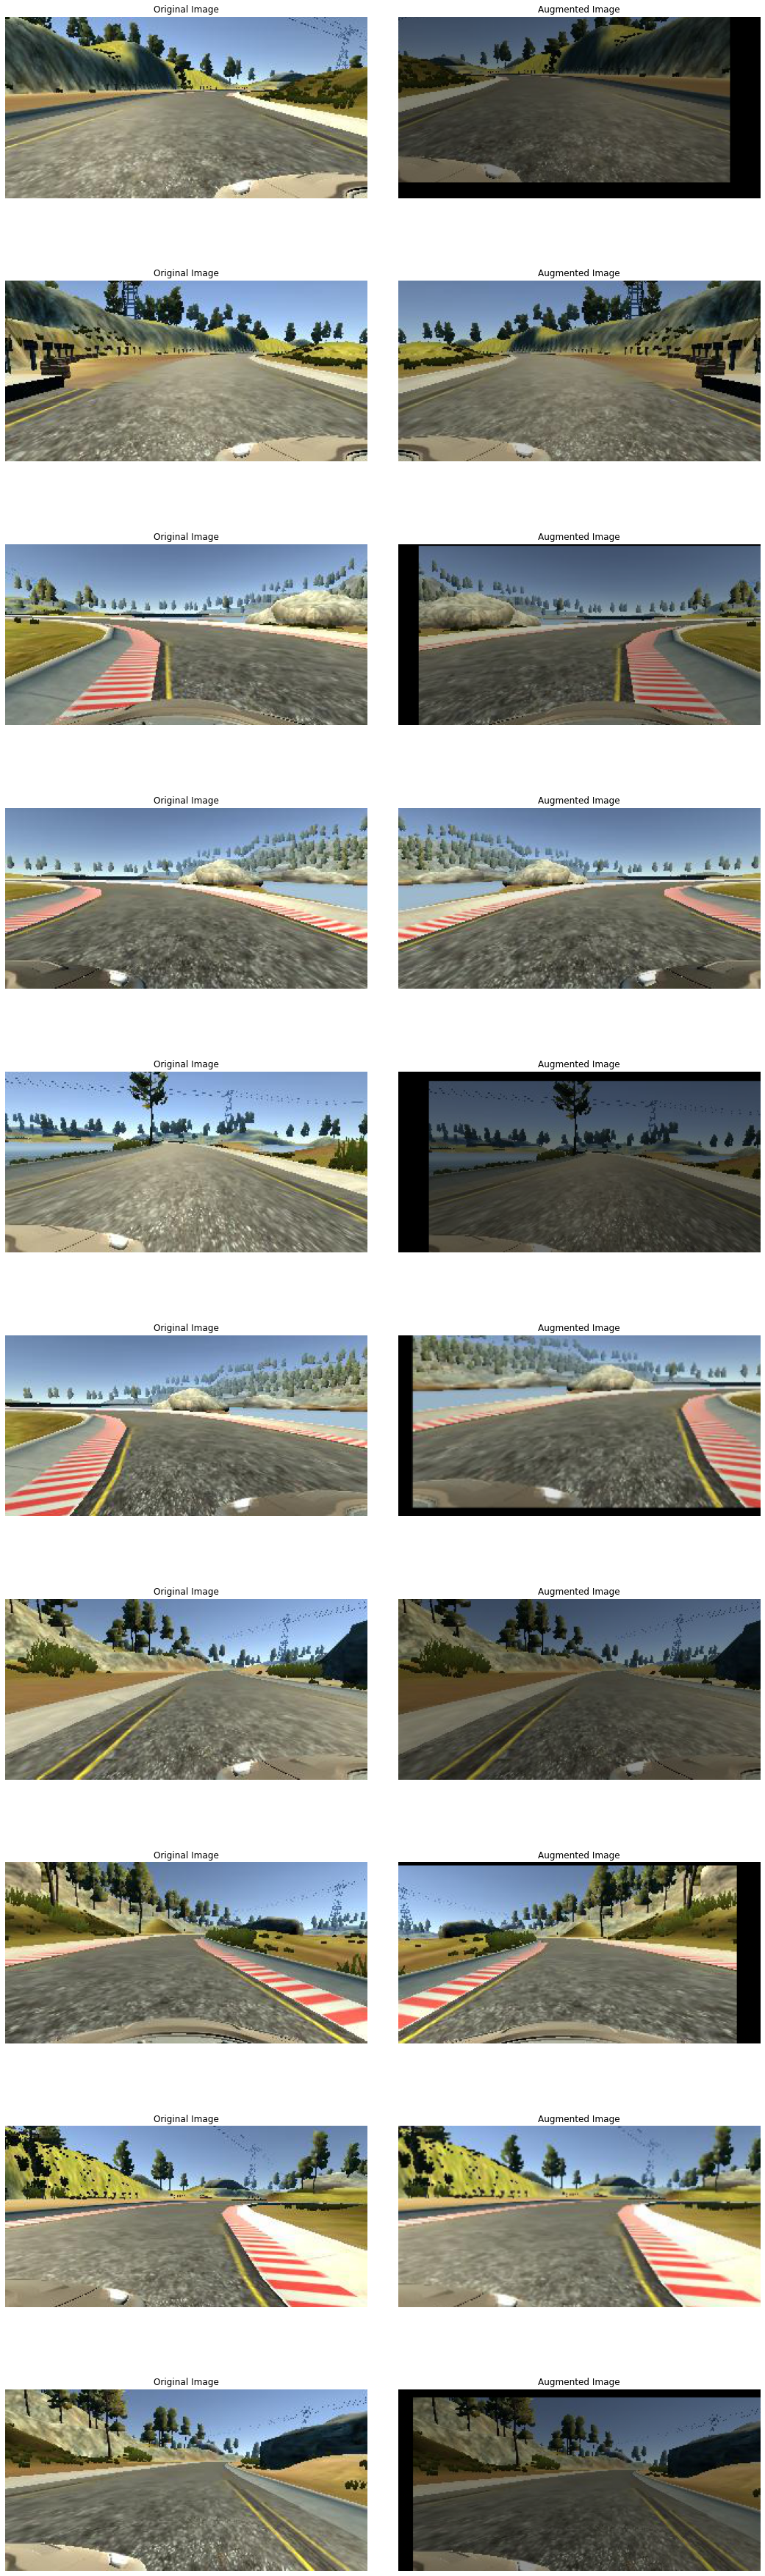

In [35]:
ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]

  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)

  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  axs[i][0].axis('off')
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")
  axs[i][1].axis('off')
fig.savefig('Random_augmentation.png')

In [0]:
def img_preprocess(img, read_img = True):
  if read_img:
    img = mpimg.imread(img)
  img = img[60:135, :, :]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200,66))
  img = img/255
  return img

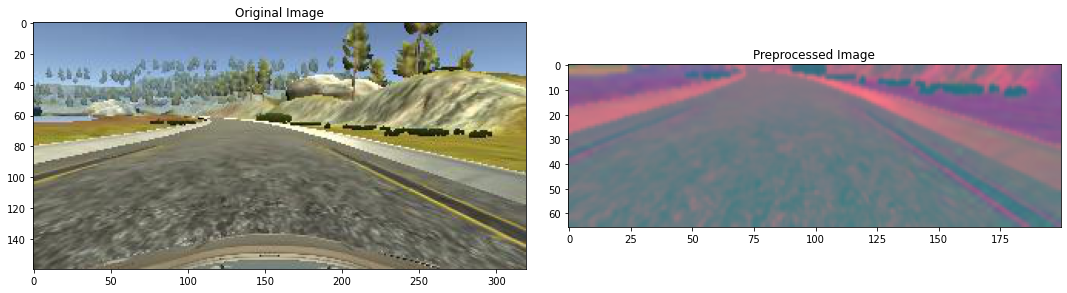

In [38]:
image = image_paths[201]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axes = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')
fig.savefig('Preprocessing_image.png')


In [0]:
X_train_pro = np.array(list(map(img_preprocess, X_train)))
X_valid_pro = np.array(list(map(img_preprocess, X_valid)))


(4478, 66, 200, 3)


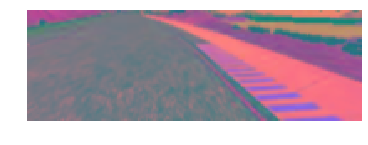

In [0]:
plt.imshow(X_train_pro[random.randint(0, len(X_train_pro)-1)])
plt.axis('off')
print(X_train_pro.shape)

In [0]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im, read_img = False)
      batch_img.append(im)
      batch_steering.append(steering)
      
    yield np.asarray(batch_img), np.asarray(batch_steering)

Text(0.5, 1.0, 'Validation Image')

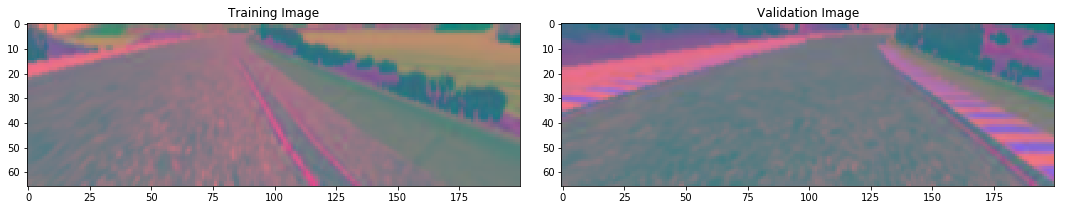

In [0]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))
# x_train_gen, y_train_gen = batch_generator(X_train, y_train, 1, 1)
# x_valid_gen, y_valid_gen = batch_generator(X_valid, y_valid, 1, 0)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [0]:
def nvidia_model():
  model = Sequential()
  # using relu activation lead to dying relu problem. Gradient is zero for negative values
  model.add(Convolution2D(filters=24, kernel_size=(5,5), subsample=(2,2), input_shape=(66,200,3), activation='elu'))
  model.add(Convolution2D(filters=36, kernel_size=(5,5), subsample=(2,2), activation='elu'))
  model.add(Convolution2D(filters=48, kernel_size=(5,5), subsample=(2,2), activation='elu'))
  model.add(Convolution2D(filters=64, kernel_size=(3,3), activation='elu'))
  model.add(Convolution2D(filters=64, kernel_size=(3,3), activation='elu'))
  model.add(Dropout(rate=0.25))
  
  model.add(Flatten())
  model.add(Dense(units=100, activation='elu'))
#   model.add(Dropout(rate=0.5))
  
  model.add(Dense(units=50, activation='elu'))
#   model.add(Dropout(rate=0.5))
  
  model.add(Dense(units=10, activation='elu'))
#   model.add(Dropout(rate=0.5))

  model.add(Dense(units=1))
  
  model.compile(loss='mse', optimizer=Adam(lr=1e-3))
  
  return model

In [0]:
model = nvidia_model()
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1152)             

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=24, kernel_size=(5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=36, kernel_size=(5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=48, kernel_size=(5, 5), activation="elu", strides=(2, 2))`
  


In [0]:
# h = model.fit(x=X_train_pro, y=y_train, validation_data=(X_valid_pro, y_valid), batch_size=100, verbose=1, shuffle=1, epochs=15)
h = model.fit_generator(batch_generator(X_train, y_train, batch_size=100, istraining=1), 
                        validation_data=batch_generator(X_valid, y_valid, batch_size=100, istraining=0),
                        steps_per_epoch=300, 
                        validation_steps=200, 
                        verbose=1, shuffle=1, epochs=10)

Epoch 1/10
300/300 [==============================] - 150s 501ms/step - loss: 0.1632 - val_loss: 0.0956
Epoch 2/10
300/300 [==============================] - 146s 486ms/step - loss: 0.1117 - val_loss: 0.0819
Epoch 3/10
300/300 [==============================] - 146s 486ms/step - loss: 0.0995 - val_loss: 0.0822
Epoch 4/10
300/300 [==============================] - 146s 486ms/step - loss: 0.0934 - val_loss: 0.0741
Epoch 5/10
300/300 [==============================] - 143s 475ms/step - loss: 0.0915 - val_loss: 0.0698
Epoch 6/10
300/300 [==============================] - 146s 485ms/step - loss: 0.0882 - val_loss: 0.0715
Epoch 7/10
300/300 [==============================] - 146s 485ms/step - loss: 0.0841 - val_loss: 0.0692
Epoch 8/10
300/300 [==============================] - 146s 485ms/step - loss: 0.0830 - val_loss: 0.0724
Epoch 9/10
300/300 [==============================] - 145s 484ms/step - loss: 0.0825 - val_loss: 0.0697
Epoch 10/10
300/300 [==============================] - 146s 485m

Text(0.5, 0, 'Epochs')

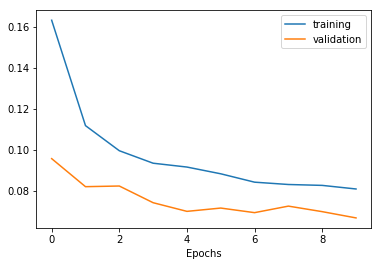

In [0]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['training','validation'])
plt.xlabel('Epochs')

In [0]:
model.save('model.h5')
import time
time.sleep(5)

In [0]:
from google.colab import files
files.download('model.h5')